## 图像增广

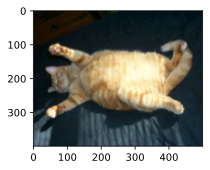

In [1]:
%matplotlib inline
import torch
import torchvision
from d2l import torch as d2l

d2l.set_figsize()
img = d2l.Image.open('../data/img/cat1.jpg')
d2l.plt.imshow(img)

In [3]:

def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

### 左右翻转图像

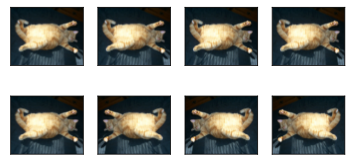

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())

### 上下翻转

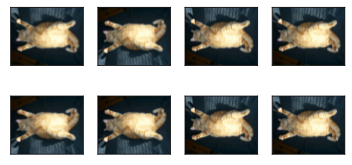

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())

### 随机裁剪

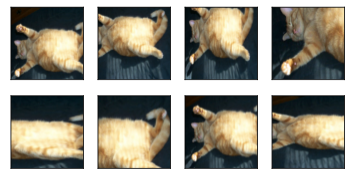

In [6]:
# (200, 200)表示最后的输出尺寸
# scale表示保存为原图的比率(保存原图的10%-100%)
# ratio 原图长宽比裁剪范围
shape_aug = torchvision.transforms.RandomResizedCrop((200, 200), scale=(0.1, 1), ratio=(0.5, 2))
apply(img, shape_aug)

### 随机改变图像的亮度

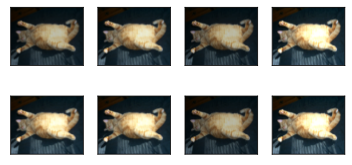

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0
))
# brightness表示亮度增大或减少50%

### 随机更改图像的色调

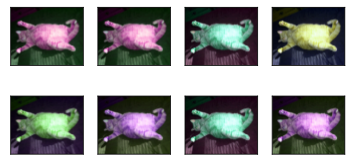

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5
))

### 随机一起更改亮度(brightness)、对比度(contrast)、饱和度(saturation) 和色调(hue)

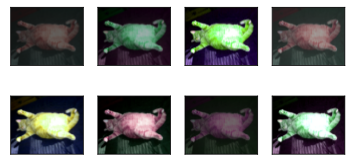

In [11]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5
)
apply(img, color_aug)

### 结合多种图像增广方法

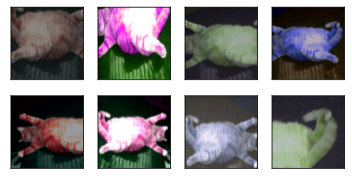

In [12]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    color_aug, shape_aug
])
apply(img, augs)

### 使用图像增广进行训练

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

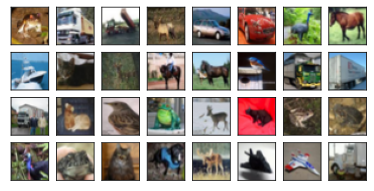

In [13]:
all_imgs = torchvision.datasets.CIFAR10(train=True, root="../data", download=True)
d2l.show_images([all_imgs[i][0] for i in range(32)], 4, 8, scale=0.8)

### 只使用最简单的随机左右翻转
（测试集比较简单，且没有太多不一样的地方，故不用对训练数据做太多预处理）

In [14]:
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor()
])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()
])

### 定义一个辅助函数，以便于读取图像和应用图像增广

In [17]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="../data", train=is_train,
        transform=augs, download=False
    )
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=8
    )
    return dataloader

In [ ]:
def train_batch_ch13(net, X, y, loss, trainer, devices):
    if isinstance(X, list):
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

# def train_ch13(net, train_iter,)